DCGAN generating MNIST digits
===

In [1]:
import os

import torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

# import pytorch_lightning as pl

Create the Discriminator class
---

In [2]:
class Discriminator(nn.Module):
    def __init__(self, n_channels, d_features):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # N x n_channels x 64 x64
            nn.Conv2d(n_channels, d_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(.2),
            
            # N x d_features x 32 x 32
            nn.Conv2d(d_features, 2*d_features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*d_features),
            nn.LeakyReLU(.2),
            
            # N x 2*d_features x 16 x 16
            nn.Conv2d(2*d_features, 4*d_features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4*d_features),
            nn.LeakyReLU(.2),
            
            # N x 4*d_features x 8 x 8
            nn.Conv2d(4*d_features, 8*d_features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8*d_features),
            nn.LeakyReLU(.2),
            
            # N x 8*d_features x 4 x 4
            nn.Conv2d(8*d_features, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
            
            # N x 1 x 1 x 1
        )
        
    def forward(self, x):
        return self.net(x)

Create the Generator class
---

In [3]:
class Generator(nn.Module):
    def __init__(self, n_noise, n_channels, g_features):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # N x n_noise x 1 x 1
            nn.ConvTranspose2d(n_noise, 16*g_features, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(16*g_features),
            nn.ReLU(),
            
            # N x 16*g_features x 4 x 4
            nn.ConvTranspose2d(16*g_features, 8*g_features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8*g_features),
            nn.ReLU(),
            
            # N x 8*g_features x 8 x 8
            nn.ConvTranspose2d(8*g_features, 4*g_features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4*g_features),
            nn.ReLU(),
            
            # N x 4*g_features x 16 x 16
            nn.ConvTranspose2d(4*g_features, 2*g_features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*g_features),
            nn.ReLU(),
            
            # N x 2*g_features x 32 x 32
            nn.ConvTranspose2d(2*g_features, n_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            
            # N x n_channels x 64 x 64
        )
    
    def forward(self, x):
        return self.net(x)
        

Create the GAN training loop
---

In [4]:
hparams = dict(
    n_noise=10,
    n_channels=1,
    img_size=64,
    g_features=16,
    d_features=16,
    lr=.0002,
    b1=.5,
    b2=.999,
    batch_size=512,
    epochs=200,
    logdir='runs/DCGAN_MNIST-noise_10/'
)

In [5]:
transform = transforms.Compose([transforms.Resize(hparams.get('img_size')),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
dataset = MNIST('/tmp/', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=hparams.get("batch_size"))

device = torch.device("cuda:1")

discriminator = Discriminator(hparams.get('n_channels'), hparams.get('d_features')).to(device)
generator = Generator(hparams.get('n_noise'), hparams.get('n_channels'), hparams.get('g_features')).to(device)

optim_d = optim.Adam(discriminator.parameters(), lr=hparams.get('lr'), betas=(hparams.get('b1'), hparams.get('b2')))
optim_g = optim.Adam(generator.parameters(), lr=hparams.get('lr'), betas=(hparams.get('b1'), hparams.get('b2')))

discriminator.train()
generator.train()

criterion = nn.BCELoss()

fixed_noise = torch.randn(hparams.get('batch_size'), hparams.get('n_noise'), 1, 1, device=device)
writer_real = SummaryWriter(os.path.join(hparams.get('logdir'), 'test_real'))
writer_fake = SummaryWriter(os.path.join(hparams.get('logdir'), 'test_fake'))
writer_idx = 0

for epoch in range(hparams.get('epochs')):
    for batch_idx, (data, targets) in enumerate(dataloader):
        data = data.to(device)
        batch_size = data.shape[0]
        
        # Train discriminator
        discriminator.zero_grad()
        real_label = .9 * torch.ones(batch_size, device=device)
        real_hat = discriminator(data).reshape(-1)
        real_loss = criterion(real_hat, real_label)
        
        noise = torch.randn(batch_size, hparams.get('n_noise'), 1, 1, device=device)
        fake_gen = generator(noise)
        fake_hat = discriminator(fake_gen.detach()).reshape(-1)
        fake_label = .1 * torch.ones(batch_size, device=device)
        fake_loss = criterion(fake_hat, fake_label)
        
        discriminator_loss = real_loss + fake_loss
        discriminator_loss.backward()
        optim_d.step()
        
        # Train generator
        generator.zero_grad()
        label = torch.ones(batch_size, device=device)
        label_hat = discriminator(fake_gen).reshape(-1)
        generator_loss = criterion(label_hat, label)
        generator_loss.backward()
        optim_g.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}/{hparams.get("epochs")} : Batch {batch_idx}/{len(dataloader)} : LossD {discriminator_loss:.3e} : LossG {generator_loss:.3e}')
            
            with torch.no_grad():
                fake_img = generator(fixed_noise)
                
                img_grid_real = torchvision.utils.make_grid(data[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake_img[:32], normalize=True)
                writer_fake.add_image('Mnist fake image', img_grid_fake, writer_idx)
                writer_real.add_image('Mnist real image', img_grid_real, writer_idx)
                writer_idx += 1
    

Epoch 0/200 : Batch 0/118 : LossD 1.544e+00 : LossG 9.082e-01
Epoch 0/200 : Batch 100/118 : LossD 6.588e-01 : LossG 2.623e+00
Epoch 1/200 : Batch 0/118 : LossD 6.582e-01 : LossG 2.873e+00
Epoch 1/200 : Batch 100/118 : LossD 6.888e-01 : LossG 3.054e+00
Epoch 2/200 : Batch 0/118 : LossD 7.033e-01 : LossG 2.190e+00
Epoch 2/200 : Batch 100/118 : LossD 8.855e-01 : LossG 2.090e+00
Epoch 3/200 : Batch 0/118 : LossD 7.792e-01 : LossG 2.845e+00
Epoch 3/200 : Batch 100/118 : LossD 8.905e-01 : LossG 1.799e+00
Epoch 4/200 : Batch 0/118 : LossD 7.830e-01 : LossG 1.899e+00
Epoch 4/200 : Batch 100/118 : LossD 1.138e+00 : LossG 7.641e-01
Epoch 5/200 : Batch 0/118 : LossD 2.093e+00 : LossG 2.902e-01
Epoch 5/200 : Batch 100/118 : LossD 1.067e+00 : LossG 1.005e+00
Epoch 6/200 : Batch 0/118 : LossD 1.058e+00 : LossG 1.070e+00
Epoch 6/200 : Batch 100/118 : LossD 1.128e+00 : LossG 7.682e-01
Epoch 7/200 : Batch 0/118 : LossD 1.611e+00 : LossG 3.668e-01
Epoch 7/200 : Batch 100/118 : LossD 1.047e+00 : LossG 8.

Epoch 64/200 : Batch 100/118 : LossD 7.071e-01 : LossG 2.316e+00
Epoch 65/200 : Batch 0/118 : LossD 7.237e-01 : LossG 1.831e+00
Epoch 65/200 : Batch 100/118 : LossD 6.878e-01 : LossG 2.034e+00
Epoch 66/200 : Batch 0/118 : LossD 8.048e-01 : LossG 1.797e+00
Epoch 66/200 : Batch 100/118 : LossD 6.921e-01 : LossG 2.015e+00
Epoch 67/200 : Batch 0/118 : LossD 7.250e-01 : LossG 1.922e+00
Epoch 67/200 : Batch 100/118 : LossD 6.850e-01 : LossG 2.368e+00
Epoch 68/200 : Batch 0/118 : LossD 1.009e+00 : LossG 3.081e+00
Epoch 68/200 : Batch 100/118 : LossD 7.350e-01 : LossG 2.635e+00
Epoch 69/200 : Batch 0/118 : LossD 6.939e-01 : LossG 1.963e+00
Epoch 69/200 : Batch 100/118 : LossD 6.755e-01 : LossG 2.272e+00
Epoch 70/200 : Batch 0/118 : LossD 7.201e-01 : LossG 1.621e+00
Epoch 70/200 : Batch 100/118 : LossD 8.323e-01 : LossG 1.792e+00
Epoch 71/200 : Batch 0/118 : LossD 8.250e-01 : LossG 1.178e+00
Epoch 71/200 : Batch 100/118 : LossD 6.955e-01 : LossG 2.281e+00
Epoch 72/200 : Batch 0/118 : LossD 7.24

Epoch 128/200 : Batch 100/118 : LossD 6.755e-01 : LossG 2.378e+00
Epoch 129/200 : Batch 0/118 : LossD 7.172e-01 : LossG 2.076e+00
Epoch 129/200 : Batch 100/118 : LossD 6.673e-01 : LossG 2.339e+00
Epoch 130/200 : Batch 0/118 : LossD 6.689e-01 : LossG 2.333e+00
Epoch 130/200 : Batch 100/118 : LossD 6.903e-01 : LossG 2.107e+00
Epoch 131/200 : Batch 0/118 : LossD 6.940e-01 : LossG 2.221e+00
Epoch 131/200 : Batch 100/118 : LossD 6.666e-01 : LossG 2.221e+00
Epoch 132/200 : Batch 0/118 : LossD 6.676e-01 : LossG 2.492e+00
Epoch 132/200 : Batch 100/118 : LossD 6.666e-01 : LossG 2.493e+00
Epoch 133/200 : Batch 0/118 : LossD 7.991e-01 : LossG 1.986e+00
Epoch 133/200 : Batch 100/118 : LossD 7.016e-01 : LossG 1.884e+00
Epoch 134/200 : Batch 0/118 : LossD 7.626e-01 : LossG 1.789e+00
Epoch 134/200 : Batch 100/118 : LossD 6.735e-01 : LossG 2.575e+00
Epoch 135/200 : Batch 0/118 : LossD 6.650e-01 : LossG 2.399e+00
Epoch 135/200 : Batch 100/118 : LossD 6.683e-01 : LossG 2.049e+00
Epoch 136/200 : Batch 0/

Epoch 192/200 : Batch 0/118 : LossD 6.644e-01 : LossG 2.433e+00
Epoch 192/200 : Batch 100/118 : LossD 6.627e-01 : LossG 2.380e+00
Epoch 193/200 : Batch 0/118 : LossD 7.220e-01 : LossG 2.060e+00
Epoch 193/200 : Batch 100/118 : LossD 6.803e-01 : LossG 2.352e+00
Epoch 194/200 : Batch 0/118 : LossD 6.689e-01 : LossG 2.239e+00
Epoch 194/200 : Batch 100/118 : LossD 6.728e-01 : LossG 2.233e+00
Epoch 195/200 : Batch 0/118 : LossD 6.665e-01 : LossG 2.477e+00
Epoch 195/200 : Batch 100/118 : LossD 6.656e-01 : LossG 2.394e+00
Epoch 196/200 : Batch 0/118 : LossD 6.635e-01 : LossG 2.425e+00
Epoch 196/200 : Batch 100/118 : LossD 6.624e-01 : LossG 2.588e+00
Epoch 197/200 : Batch 0/118 : LossD 7.526e-01 : LossG 1.910e+00
Epoch 197/200 : Batch 100/118 : LossD 6.619e-01 : LossG 2.547e+00
Epoch 198/200 : Batch 0/118 : LossD 6.656e-01 : LossG 2.611e+00
Epoch 198/200 : Batch 100/118 : LossD 6.981e-01 : LossG 3.302e+00
Epoch 199/200 : Batch 0/118 : LossD 7.130e-01 : LossG 2.290e+00
Epoch 199/200 : Batch 100/

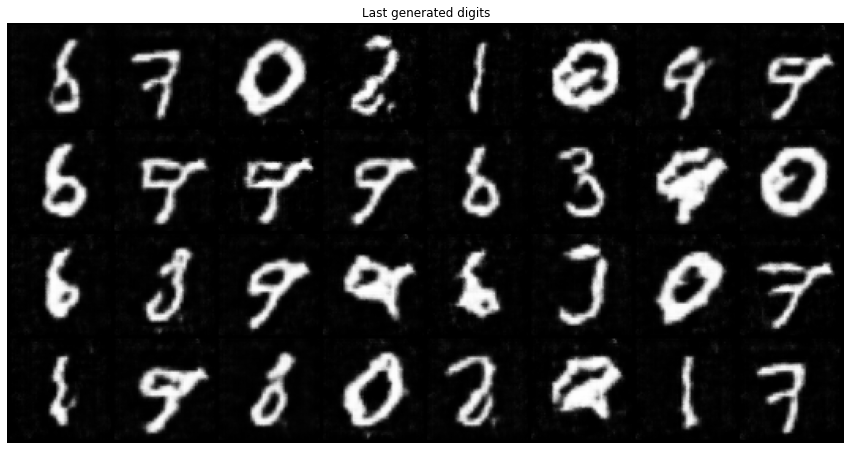

In [27]:
import matplotlib.pyplot as plt
last_generated_grid = img_grid_fake.detach().cpu().permute(1,2,0).numpy()

fig, ax = plt.subplots(figsize=(15,12))
ax.set_title('Last generated digits')
ax.axis('off')
ax.imshow(last_generated_grid, cmap='gray')
plt.show()